## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with the nuisance parameter bias to compute the fluxpoints

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../../../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Import

In [2]:
config = Dataset_load.load_config()
colors = config['colors']['three']

colors
import ast

colors[1] = ast.literal_eval(colors[1])
colors[2] = ast.literal_eval(colors[2])
colors[3] = ast.literal_eval(colors[3])

### Datasets

In [3]:
scaled_amplitude = Parameter("amplitude", value=1e-11)
lambda_ = Parameter("lambda_", value=1 / 60)

dataset_input = Dataset_load.create_asimov(
    model="ecpl", source="PKSflare", parameters=Parameters([scaled_amplitude, lambda_])
)

loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


In [4]:
norm = 0.0
tilt = 0.0
bias = 0.1
resolution = 0.0

In [5]:
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
dataset_asimov_N.models.parameters['resolution'].frozen = True
dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
dataset_asimov_N.irf_model.parameters['norm'].frozen = True
setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

In [10]:
%%time
fitting = 1
if fitting :
    fit = Fit(store_trace=False)
    result = fit.run(dataset_asimov)
    fit_N = Fit(store_trace=False)
    result_N = fit_N.run(dataset_asimov_N)
    dataset_asimov_N.models.write( f"data/2_model_N.yml",overwrite = True)
    dataset_asimov.models.write( f"data/2_model.yml",overwrite = True)
    
else:
    m  = Models.read("data/2_model.yml")
    dataset_asimov.models = Models([m[0], FoVBackgroundModel(dataset_name=dataset_asimov.name), ])
    path = f"data/2_model_N.yml"
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path)
    dataset_asimov_N.irf_model.eff_area_model.parameters.freeze_all()
    dataset_asimov_N.irf_model.parameters["resolution"].frozen = True
    dataset_asimov_N.irf_model.parameters["bias"].frozen = False

CPU times: user 13min 31s, sys: 9min 4s, total: 22min 36s
Wall time: 7min 1s


In [11]:
mask = dataset_asimov.mask.data[:,200,200]
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV

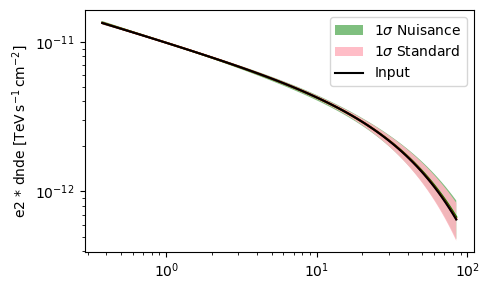

In [12]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, axs = plt.subplots(1,1, figsize = (5,3))

dataset_asimov_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "green")    

dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", color = "red", alpha = 0.9)    

dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "lightpink",
                                                   alpha = 0.9)

dataset_input.models[0].spectral_model.plot(energy_bounds, linestyle='-', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )

axs.set_xlabel('')
axs.legend()
plt.tight_layout()


## Compute Asimov Fluxpoints


In [14]:
comput_fp = 1
if comput_fp :
    energy_edges = dataset_asimov.geoms["geom"].axes[0].edges[::2]
    esti = FluxPointsEstimator(energy_edges=energy_edges)
    fluxpoints = esti.run([dataset_asimov])
    fluxpoints.write(
        "data/fluxpoints/2_fluxpoints_asimov.fits", overwrite = True
    )
    Models([dataset_asimov.models[0]]).write(
        "data/fluxpoints/2_model_asimov.fits" , overwrite = True
    )
    
    fluxpoints_N = esti.run([dataset_asimov_N])
    fluxpoints_N.write(
        f"data/fluxpoints/2_fluxpoints_asimov_N.fits", overwrite= True,
    )
    Models([dataset_asimov_N.models[0]]).write(
        f"data/fluxpoints/2_model_asimov_N.fits", overwrite= True,
    )
    
    fp_asimov = FluxPointsDataset(data = fluxpoints, models = Models([dataset_asimov.models[0]]))
    fp_asimov_N = FluxPointsDataset(data = fluxpoints_N, models = Models([dataset_asimov_N.models[0]]))
    
else:
    fp_asimov = FluxPointsDataset(data = FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov.fits"),
                                 models = Models.read("data/fluxpoints/2_model_asimov.fits"))
    fp_asimov_N = FluxPointsDataset(data = FluxPoints.read("data/fluxpoints/2_fluxpoints_asimov_N.fits"),
                                 models = Models.read("data/fluxpoints/2_model_asimov_N.fits"))


0.10000000000000002 TeV 0.1778279410038923 TeV

0.1778279410038923 TeV 0.316227766016838 TeV

0.316227766016838 TeV 0.5623413251903491 TeV

0.5623413251903491 TeV 1.0 TeV

1.0 TeV 1.7782794100389232 TeV

1.7782794100389232 TeV 3.1622776601683795 TeV

3.1622776601683795 TeV 5.623413251903489 TeV

5.623413251903489 TeV 10.000000000000002 TeV

10.000000000000002 TeV 17.78279410038923 TeV

17.78279410038923 TeV 31.62277660168379 TeV

31.62277660168379 TeV 56.234132519034915 TeV

56.234132519034915 TeV 100.00000000000004 TeV

0.10000000000000002 TeV 0.1778279410038923 TeV

0.1778279410038923 TeV 0.316227766016838 TeV

0.316227766016838 TeV 0.5623413251903491 TeV

0.5623413251903491 TeV 1.0 TeV

1.0 TeV 1.7782794100389232 TeV

1.7782794100389232 TeV 3.1622776601683795 TeV

3.1622776601683795 TeV 5.623413251903489 TeV

5.623413251903489 TeV 10.000000000000002 TeV

10.000000000000002 TeV 17.78279410038923 TeV

17.78279410038923 TeV 31.62277660168379 TeV

31.62277660168379 TeV 56.2341325190349

In [15]:
def plot_shifted (ff, shift):
    return ff.energy_ref* shift, ff.e2dnde.data[:,0,0],  ff.e2dnde_err.data[:,0,0], 

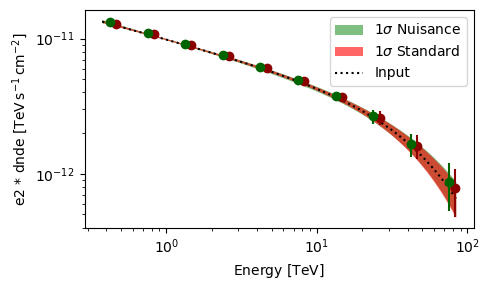

In [16]:
fig, axs = plt.subplots(1,1, figsize = (5,3))
dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.6)

dataset_input.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )



e_, f_, ferr_ = plot_shifted(fp_asimov.data, 1.1)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='o')  

e_, f_, ferr_ = plot_shifted(fp_asimov_N.data, 1.)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='o')  


axs.legend()
plt.tight_layout()


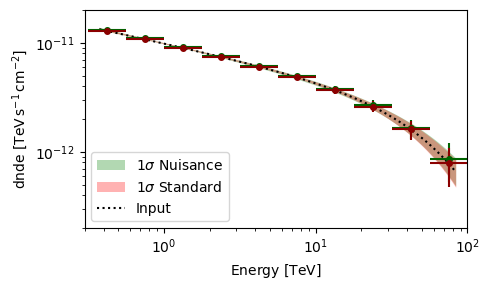

In [19]:
energy_power = 2
fig, axs = plt.subplots(1,1, figsize = (5,3))
dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.3)    
    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.3)

dataset_input.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = energy_power, ax = axs,
                                label = "Input", color = "black", )





fp_asimov_N.data.plot(energy_power = energy_power,  color = 'darkgreen', fmt='o')  
fp_asimov.data.plot(energy_power =energy_power,  color = 'darkred', fmt='x')  

axs.set_xlim(0.3, 100)
axs.set_ylim(2e-13, 2e-11)
axs.legend()
plt.tight_layout()


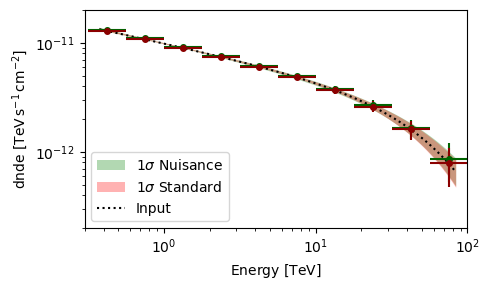

In [23]:
energy_power = 2
fig, axs = plt.subplots(1,1, figsize = (5,3))
fp_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.3)    
    
fp_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.3)

dataset_input.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = energy_power, ax = axs,
                                label = "Input", color = "black", )





fp_asimov_N.data.plot(energy_power = energy_power,  color = 'darkgreen', fmt='o')  
fp_asimov.data.plot(energy_power =energy_power,  color = 'darkred', fmt='x')  

axs.set_xlim(0.3, 100)
axs.set_ylim(2e-13, 2e-11)
axs.legend()
plt.tight_layout()
